# Emotion Detection using FER2013

In [1]:
import tensorflow as tf

print("TF version:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

2026-02-21 09:45:39.995766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771667140.187583      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771667140.239371      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771667140.697124      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771667140.697169      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771667140.697176      24 computation_placer.cc:177] computation placer alr

TF version: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("/kaggle/input/datasets/mikundas/fer2013/fer2013.csv")

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.shape

(35887, 3)

In [6]:
df["Usage"].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


## Convert Pixel string-> Image Array

In [8]:
import matplotlib.pyplot as plt

In [9]:
pixels = df["pixels"][0]
pixels = np.array(pixels.split(), dtype="float32")
pixels = pixels.reshape(48, 48)

print(pixels.shape)

(48, 48)


In [10]:
pixels

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32)

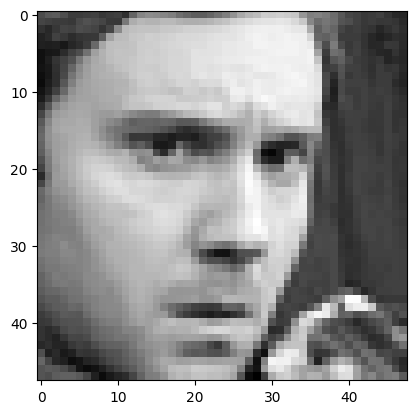

In [11]:
plt.imshow(pixels, cmap="gray")
plt.show()

### Converting whoel dataset to image array

In [12]:
images = []
labels = []

for index, row in df.iterrows():
    pixel_values = np.array(row["pixels"].split(), dtype="float32")
    pixel_values = pixel_values.reshape(48, 48, 1)

    images.append(pixel_values)
    labels.append(row["emotion"])

In [13]:
images = np.array(images)
labels = np.array(labels)

### Normalizing the Images

In [14]:
images = images / 255.0

### Checking Final Shape

In [15]:
print(images.shape)
print(labels.shape)

(35887, 48, 48, 1)
(35887,)


## Create Train, Val, Test Split using `Usage` column
* Do everything we have done bofore for train, val, and test sets
* For doing that we need to func 

In [16]:
df["Usage"].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [17]:
train_data = df[df["Usage"] == "Training"]
val_data = df[df["Usage"] == "PublicTest"]
test_data = df[df["Usage"] == "PrivateTest"]

### Convert Each Split into Image & Labels

In [18]:
import numpy as np
import pandas as pd

def process_data_optimized(df):
    # 1. Vectorized split: Convert the entire column of strings to a single NumPy array
    # This avoids the overhead of millions of small Python string objects
    pixel_series = df['pixels'].str.split(' ', expand=True).values.astype('float32')
    
    # 2. Reshape the entire block at once
    # Result: (num_samples, 48, 48, 1)
    images = pixel_series.reshape(-1, 48, 48, 1)
    
    # 3. Normalize in-place to save memory
    images /= 255.0
    
    # 4. Convert labels
    labels = df['emotion'].values
    
    return images, labels


In [19]:
X_train, y_train = process_data_optimized(train_data)
X_val, y_val = process_data_optimized(val_data)
X_test, y_test = process_data_optimized(test_data)

In [20]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(28709, 48, 48, 1) (28709,)
(3589, 48, 48, 1) (3589,)
(3589, 48, 48, 1) (3589,)


### Converting Labels to Categorical

In [21]:
from tensorflow.keras.utils import to_categorical

In [22]:
max(y_train)

np.int64(6)

In [23]:
min(y_train)

np.int64(0)

In [24]:
y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

## Now build the model
* Build CNN model using FER2013 dataset

In [25]:
from tensorflow.keras import layers, models
import keras

In [26]:
model = models.Sequential()

# input shape
model.add(keras.Input(shape=(48, 48, 1)))
# first layer / input layer
model.add(layers.Conv2D(32, # filter
                        (3, 3), # Kernel size
                        activation="relu", # activation function
                       ))
model.add(layers.MaxPooling2D(2, 2))

# hidden layer 1
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))

# hidden layer 2
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(7, activation="softmax"))

I0000 00:00:1771667236.988485      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### Compile the model

In [27]:
model.compile(
    optimizer="adam",
    loss = "categorical_crossentropy",
    metrics=['accuracy']
)

### Train the model

In [28]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data= (X_val, y_val)
)

Epoch 1/20


I0000 00:00:1771667241.622552      65 service.cc:152] XLA service 0x7b8018003be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771667241.622595      65 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771667242.034549      65 cuda_dnn.cc:529] Loaded cuDNN version 91002


 25/225 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2050 - loss: 1.8785

I0000 00:00:1771667245.127988      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.2442 - loss: 1.8206 - val_accuracy: 0.3664 - val_loss: 1.6073
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3746 - loss: 1.6065 - val_accuracy: 0.4556 - val_loss: 1.4437
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4312 - loss: 1.4646 - val_accuracy: 0.4909 - val_loss: 1.3509
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4729 - loss: 1.3755 - val_accuracy: 0.4996 - val_loss: 1.3198
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4943 - loss: 1.3200 - val_accuracy: 0.5208 - val_loss: 1.2659
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5181 - loss: 1.2720 - val_accuracy: 0.5269 - val_loss: 1.2306
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5397 - loss: 1.2141 - val_accuracy: 0.5325 - val_loss: 1.2166
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5497 - loss: 1.1918 - val_accuracy: 0.5447 - va

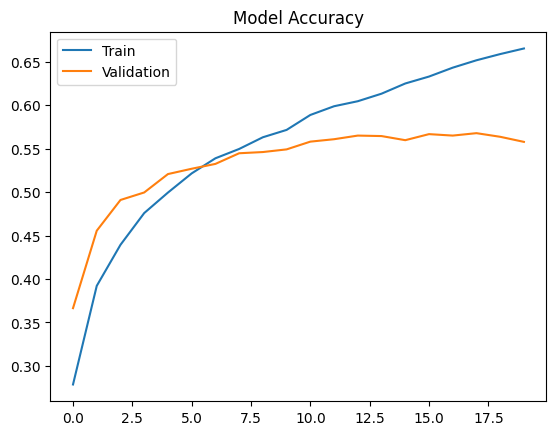

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(["Train", "Validation"])
plt.show()


# Let's Improve more
### Data Augmentation

* It artificially creates new training images by modifying existing ones
#### For example transformation like:
* Rotation
* Zoom
* Flip
* Slight Shift

In [30]:
import scipy

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
    )

In [33]:
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=128
)

## Batch Normalization
It normalizes layer outputs.
* Think like it prevents vanishing gradients and often improves accuracy

In [34]:
from tensorflow.keras import layers, models
import keras

In [35]:
model = models.Sequential()

# Input layers size of array/image
model.add(keras.Input(shape=(48, 48, 1)))

# Block 1
model.add(layers.Conv2D(32, (3, 3),padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPool2D(2,2))

# Block 2
model.add(layers.Conv2D(64, (3,3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPool2D(2,2))

# Block 3
model.add(layers.Conv2D(128, (3,3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPool2D(2,2))

# Dense Layers
model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.Dropout(0.3))
model.add(layers.Dense(7))
model.add(layers.Activation("softmax"))

In [36]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

# Defining the callback
early_stop = EarlyStopping(
    monitor = "val_loss",
    patience=10,
    restore_best_weights=True
)

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_emotion_model.keras",
    monitor="val_loss",
    save_best_only=True
)

In [39]:
history = model.fit(
    train_generator,
    epochs = 100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.2723 - loss: 1.9096 - val_accuracy: 0.2636 - val_loss: 1.9693
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.3859 - loss: 1.5837 - val_accuracy: 0.3753 - val_loss: 1.5539
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.4424 - loss: 1.4448 - val_accuracy: 0.4113 - val_loss: 1.4753
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.4758 - loss: 1.3774 - val_accuracy: 0.4661 - val_loss: 1.3875
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.4968 - loss: 1.3192 - val_accuracy: 0.5052 - val_loss: 1.2983
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.5105 - loss: 1.2804 - val_accuracy: 0.5180 - val_loss: 1.2738
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.5248 - loss: 1.2549 - val_accuracy: 0.5497 - val_loss: 1.1841
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.5322 - loss: 1.2306 - val_

In [40]:
best_model = models.load_model("best_emotion_model.keras")

In [41]:
best_model.evaluate(X_test, y_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5612 - loss: 1.1512


[1.150511384010315, 0.568682074546814]

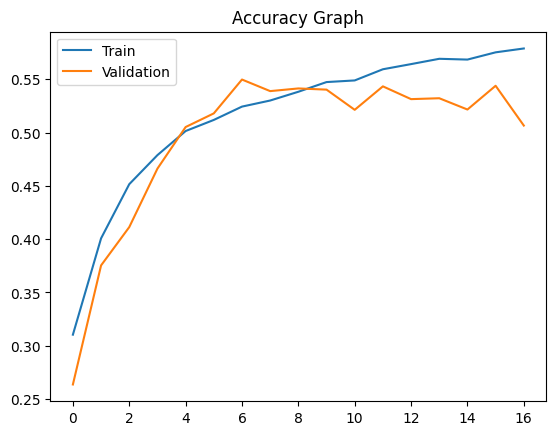

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title("Accuracy Graph")
plt.show()

# Transfer Learning

### Convert Dataset image array from(48, 48) -> (96, 96) 

In [43]:
import tensorflow as tf

In [44]:
import cv2

def preprocess_transfer(X):
    new_images = []
    
    for img in X:
        img = cv2.resize(img, (96,96))
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        new_images.append(img)
        
    return np.array(new_images)

In [45]:
X_train_t = preprocess_transfer(X_train)
X_val_t = preprocess_transfer(X_val)
X_test_t = preprocess_transfer(X_test)

In [46]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

In [47]:
train_generator = train_datagen.flow(
    X_train_t, y_train,
    batch_size=128
)

In [48]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2B0

In [49]:
base_model_mob = MobileNetV2(
    input_shape=(96,96,3),
    include_top=False,
    weights="imagenet"
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [50]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

In [51]:
base_model_mob.trainable = False

In [52]:
model = tf.keras.Sequential([
    base_model_mob,
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(256, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(7, activation="softmax")
])

In [53]:
from tensorflow.keras.optimizers import Adam
Adam = tf.keras.optimizers.Adam(
    learning_rate=5e-6, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-08)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    verbose=1,
    patience=5,
    restore_best_weights=True
)

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_emotion_model_mob.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [56]:
model.compile(
    optimizer=Adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [57]:
history = model.fit(
    train_generator,
    validation_data=(X_val_t, y_val),
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.1789 - loss: 2.4735
Epoch 1: val_loss improved from inf to 2.14558, saving model to best_emotion_model_mob.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 98s 380ms/step - accuracy: 0.1790 - loss: 2.4733 - val_accuracy: 0.2251 - val_loss: 2.1456
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.2026 - loss: 2.3094
Epoch 2: val_loss improved from 2.14558 to 2.03362, saving model to best_emotion_model_mob.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 309ms/step - accuracy: 0.2026 - loss: 2.3093 - val_accuracy: 0.2558 - val_loss: 2.0336
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.2297 - loss: 2.2035
Epoch 3: val_loss improved from 2.03362 to 1.95320, saving model to best_emotion_model_mob.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 68s 303ms/step - accuracy: 0.2297 - loss: 2.2034 - val_accuracy: 0.2820 - val_loss: 1.9532
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.2425 - loss: 2.1419
E

In [58]:
base_model_mob.trainable = True

In [59]:
for layer in base_model_mob.layers[:-20]:
    layer.trainable = False

In [60]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=1e-5, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-08)

In [61]:
model.compile(
    optimizer=Adam,#1e-5 5e-6
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [62]:
history = model.fit(
    X_train_t, y_train,
    validation_data=(X_val_t, y_val),
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50


2026-02-21 10:16:41.774760: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:16:41.957586: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:16:42.217220: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:16:42.421993: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3055 - loss: 1.9003

2026-02-21 10:16:59.748113: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:16:59.930210: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3055 - loss: 1.9002
Epoch 1: val_loss did not improve from 1.60766
898/898 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.3055 - loss: 1.9001 - val_accuracy: 0.3870 - val_loss: 1.7200
Epoch 2/50
894/898 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3903 - loss: 1.6715
Epoch 2: val_loss improved from 1.60766 to 1.49858, saving model to best_emotion_model_mob.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.3904 - loss: 1.6713 - val_accuracy: 0.4388 - val_loss: 1.4986
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4306 - loss: 1.5448
Epoch 3: val_loss improved from 1.49858 to 1.42309, saving model to best_emotion_model_mob.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.4306 - loss: 1.5448 - val_accuracy: 0.4678 - val_loss: 1.4231
Epoch 4/50
895/898 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4552 - loss: 1.4567
Epoch 4: val_loss improved from 1.42309 to 1.37590, saving model 

In [63]:
best_model_mob = models.load_model("best_emotion_model_mob.keras")

In [64]:
best_model_mob.evaluate(X_test_t, y_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5498 - loss: 1.2598


[1.2325869798660278, 0.5567010045051575]

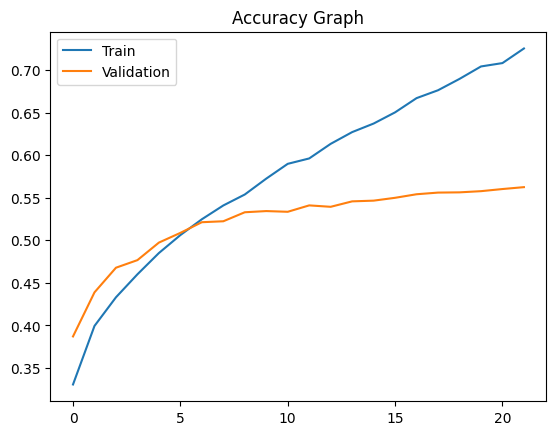

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['Train', 'Validation'])
plt.title("Accuracy Graph")
plt.show()

In [66]:
base_model_eff = EfficientNetV2B0(
    input_shape=(96,96,3),
    include_top=False,
    weights="imagenet"
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [67]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

In [68]:
base_model_mob.trainable = False

In [69]:
model = tf.keras.Sequential([
    base_model_eff,
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(256, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(7, activation="softmax")
])

In [70]:
from tensorflow.keras.optimizers import Adam
Adam = tf.keras.optimizers.Adam(
    learning_rate=5e-6, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-08)

In [71]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    verbose=1,
    patience=5,
    restore_best_weights=True
)

In [72]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_emotion_model_eff.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [73]:
model.compile(
    optimizer=Adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [74]:
history = model.fit(
    train_generator,
    validation_data=(X_val_t, y_val),
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20


2026-02-21 10:22:44.987294: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:22:45.176105: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:22:45.734694: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:22:45.926258: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:22:46.227252: E external/local_xla/xla/stream_

171/225 ━━━━━━━━━━━━━━━━━━━━ 16s 309ms/step - accuracy: 0.1076 - loss: 2.6823

2026-02-21 10:24:21.105926: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:24:21.289766: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:24:21.773011: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:24:21.965936: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 10:24:22.256574: E external/local_xla/xla/stream_

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.1087 - loss: 2.6751
Epoch 1: val_loss improved from inf to 2.22413, saving model to best_emotion_model_eff.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 216s 567ms/step - accuracy: 0.1087 - loss: 2.6750 - val_accuracy: 0.1170 - val_loss: 2.2241
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.1258 - loss: 2.5629
Epoch 2: val_loss improved from 2.22413 to 2.19606, saving model to best_emotion_model_eff.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 72s 321ms/step - accuracy: 0.1259 - loss: 2.5627 - val_accuracy: 0.1452 - val_loss: 2.1961
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.1483 - loss: 2.4449
Epoch 3: val_loss improved from 2.19606 to 2.13367, saving model to best_emotion_model_eff.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 73s 325ms/step - accuracy: 0.1483 - loss: 2.4448 - val_accuracy: 0.1638 - val_loss: 2.1337
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.1584 - loss: 2.3675
Epoch 4: va

In [75]:
base_model_eff.trainable = True

In [76]:
for layer in base_model_eff.layers[:-10]:
    layer.trainable = False

In [77]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=1e-4, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-08)

In [78]:
model.compile(
    optimizer=Adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [79]:
history = model.fit(
    train_generator,
    validation_data=(X_val_t, y_val),
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.3080 - loss: 1.8832
Epoch 1: val_loss improved from 1.66204 to 1.61314, saving model to best_emotion_model_eff.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 115s 391ms/step - accuracy: 0.3080 - loss: 1.8831 - val_accuracy: 0.3848 - val_loss: 1.6131
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.3343 - loss: 1.7841
Epoch 2: val_loss improved from 1.61314 to 1.59173, saving model to best_emotion_model_eff.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 65s 287ms/step - accuracy: 0.3343 - loss: 1.7841 - val_accuracy: 0.3898 - val_loss: 1.5917
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.3340 - loss: 1.7586
Epoch 3: val_loss improved from 1.59173 to 1.56207, saving model to best_emotion_model_eff.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 65s 288ms/step - accuracy: 0.3341 - loss: 1.7586 - val_accuracy: 0.3934 - val_loss: 1.5621
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.3447 - loss: 1.7

In [80]:
best_model_mob = models.load_model("best_emotion_model_eff.keras")

In [81]:
best_model_mob.evaluate(X_test_t, y_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4627 - loss: 1.3901


[1.37624990940094, 0.47088325023651123]

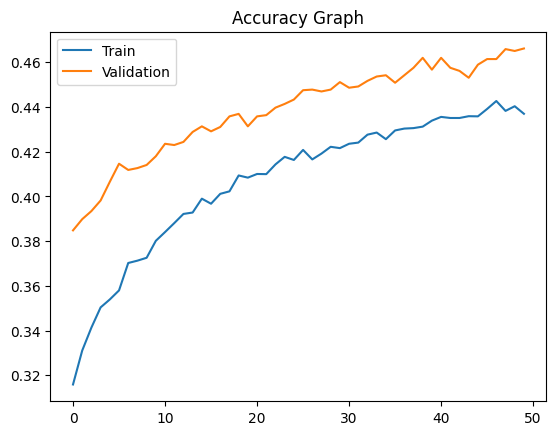

In [82]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['Train', 'Validation'])
plt.title("Accuracy Graph")
plt.show()

### Tried and test many ways but the simple Sequencial model perfomes better than others

Prediction

In [83]:
model_mob = models.load_model("best_emotion_model_mob.keras")
model_eff = models.load_model("best_emotion_model_eff.keras")
model_best = models.load_model("best_emotion_model.keras")

In [84]:
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image_keras(img_path):
    img = image.load_img(img_path, target_size=(48, 48), color_mode="grayscale")
    
    img_array = image.img_to_array(img)
    
    img_array = img_array / 255.0
    
    img_ready = np.expand_dims(img_array, axis=0)
    
    return img_ready

# Usage
processed_img = preprocess_image_keras('/kaggle/input/datasets/mikundas/images/surprise.jpg')
print(f"Shape for prediction: {processed_img.shape}")


Shape for prediction: (1, 48, 48, 1)


In [85]:
import cv2
import numpy as np

def prepare_for_mobilenet(img_path):
    # 1. Load as grayscale (FER2013 style)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # 2. Resize to exactly 96x96
    img = cv2.resize(img, (96, 96))
    
    # 3. Convert grayscale to RGB (MobileNet requires 3 channels)
    # This turns (96, 96) into (96, 96, 3)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # 4. Normalize (Important: MobileNet usually expects -1 to 1 or 0 to 1)
    img_normalized = img_rgb.astype('float32') / 255.0
    
    # 5. Reshape to (1, 96, 96, 3)
    final_input = np.expand_dims(img_normalized, axis=0)
    
    return final_input

# Predict
input_data = prepare_for_mobilenet("/kaggle/input/datasets/mikundas/images/surprise.jpg")
input_data.shape


(1, 96, 96, 3)

In [86]:
def prediction_base_predict(predicted_per):
    output = {}
    emotion_labels = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
    for label, score in zip(emotion_labels, predicted_per):
        output[label] = score
    return output
    

In [87]:
predict = model_best.predict(processed_img)[0]
predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


array([0.1280463 , 0.00971908, 0.19003011, 0.07324854, 0.3361052 ,
       0.19311562, 0.06973516], dtype=float32)

In [88]:
prediction_base_predict(predict)

{'Angry': np.float32(0.1280463),
 'Disgust': np.float32(0.0097190775),
 'Fear': np.float32(0.19003011),
 'Happy': np.float32(0.07324854),
 'Sad': np.float32(0.3361052),
 'Surprise': np.float32(0.19311562),
 'Neutral': np.float32(0.06973516)}

In [89]:
predict_mob = model_mob.predict(input_data)[0]
predict_mob

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([0.03395856, 0.03376632, 0.07109449, 0.0043027 , 0.00944181,
       0.8101113 , 0.03732487], dtype=float32)

In [90]:
prediction_base_predict(predict_mob)

{'Angry': np.float32(0.03395856),
 'Disgust': np.float32(0.03376632),
 'Fear': np.float32(0.07109449),
 'Happy': np.float32(0.0043026963),
 'Sad': np.float32(0.00944181),
 'Surprise': np.float32(0.8101113),
 'Neutral': np.float32(0.037324872)}

In [91]:
predict_eff = model_eff.predict(input_data)[0]
predict_eff

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


array([0.16050462, 0.03044251, 0.14627929, 0.30134982, 0.21781896,
       0.03186927, 0.11173558], dtype=float32)

In [92]:
prediction_base_predict(predict_eff)

{'Angry': np.float32(0.16050462),
 'Disgust': np.float32(0.03044251),
 'Fear': np.float32(0.14627929),
 'Happy': np.float32(0.30134982),
 'Sad': np.float32(0.21781896),
 'Surprise': np.float32(0.03186927),
 'Neutral': np.float32(0.11173558)}

In [93]:
from IPython.display import FileLink
# Replace 'my_model.h5' with your actual filename
FileLink(r'best_emotion_model_mob.keras')


/kaggle/working/best_emotion_model_mob.keras

In [94]:
import zipfile
import os

model_path = "best_emotion_model_mob.keras"
zip_path = "best_emotion_model_mob.zip"

# Create ZIP safely
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(model_path)

print("ZIP created:", os.path.getsize(zip_path), "bytes")
print("Model size:", os.path.getsize(model_path), "bytes")

ZIP created: 20830000 bytes
Model size: 23255057 bytes


In [95]:
import zipfile
import os

model_path = "best_emotion_model_eff.keras"
zip_path = "best_emotion_model_eff.zip"

# Create ZIP safely
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(model_path)

print("ZIP created:", os.path.getsize(zip_path), "bytes")
print("Model size:", os.path.getsize(model_path), "bytes")

ZIP created: 29948017 bytes
Model size: 33267531 bytes
